### Data Description
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

#### File and Data Field Descriptions
<br>**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

<br>&nbsp;&nbsp;&nbsp;&nbsp;**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
<br>&nbsp;&nbsp;&nbsp;&nbsp;**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
<br>&nbsp;&nbsp;&nbsp;&nbsp;**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
<br>&nbsp;&nbsp;&nbsp;&nbsp;**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
<br>&nbsp;&nbsp;&nbsp;&nbsp;**Destination** - The planet the passenger will be debarking to.
<br>&nbsp;&nbsp;&nbsp;&nbsp;**Age** - The age of the passenger.
<br>&nbsp;&nbsp;&nbsp;&nbsp;**VIP** - Whether the passenger has paid for special VIP service during the voyage.
<br>&nbsp;&nbsp;&nbsp;&nbsp;**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
<br>&nbsp;&nbsp;&nbsp;&nbsp;**Name** - The first and last names of the passenger.
<br>&nbsp;&nbsp;&nbsp;&nbsp;**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

<br>**test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
<br>**sample_submission.csv** - A submission file in the correct format.
<br>&nbsp;&nbsp;&nbsp;&nbsp;**PassengerId** - Id for each passenger in the test set.
<br>&nbsp;&nbsp;&nbsp;&nbsp;**Transported** - The target. For each passenger, predict either True or False.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator
from numpy import nan

## We will first open our files

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [3]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## First of all we need to clean the data

### First let deal Id and Cabin
We need to transform the column so that our algorithm can work with it.

In [5]:
data[['Group','SubGroup']] = data.PassengerId.str.split('_',expand=True)
data.drop('SubGroup', axis=1, inplace=True)

In [6]:
data[['Deck','Num','Side']] = data.Cabin.str.split('/', expand=True)
data = data[['Group','HomePlanet','CryoSleep','Deck','Side','Destination','Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Transported']]

We will transform the data from other columns as well.

In [7]:
data['Deck'] = data['Deck'].replace(['A','B','C','D','E','F','G','T'],[1,2,3,4,5,6,7,8])
data['Side'] = data['Side'].replace(['P','S'],[0,1])
data['HomePlanet'] = data['HomePlanet'].replace(['Earth','Europa','Mars'],[1,2,3])
data['Destination'] = data['Destination'].replace(['TRAPPIST-1e','PSO J318.5-22','55 Cancri e'],[1,2,3])
data['CryoSleep'] = data['CryoSleep'].replace([False,True],[0,1])
data['VIP'] = data['VIP'].replace([False,True],[0,1])

### Fill NaN values for Deck column

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

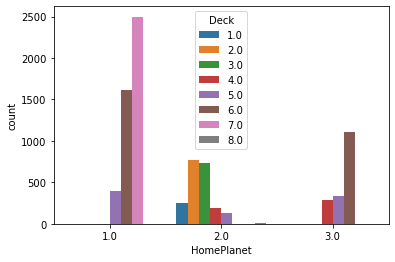

In [9]:
sns.countplot(x='HomePlanet',hue='Deck',data=data)

As we can see, for the "HomePlanet" number 3 is the most likely "Deck" number 6, so we will fill nan data with number 6.

In [10]:
data.loc[data.HomePlanet == 3, 'Deck'] = data.fillna(6)

<AxesSubplot:xlabel='CryoSleep', ylabel='count'>

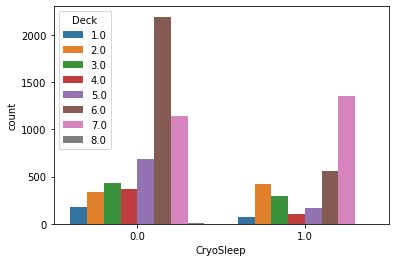

In [11]:
sns.countplot(x='CryoSleep',hue='Deck', data=data)

We can do the same for "CryoSleep" column.

In [12]:
data.loc[data.CryoSleep == 1, 'Deck'] = data.fillna(7)
#I cant do much more here, I will drop rest of the NaN data!

### Now we will do 'Side' column

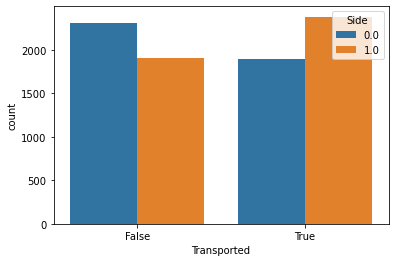

In [13]:
sns.countplot(x='Transported',hue='Side',data=data)
#There is not any correlation between this and rest columns, so l am going to drop the whole column
data.drop('Side',axis=1,inplace=True)

<b>As we can see, there is no good correlation between the side that passinger has and surviving, so we will not consider this column.

## Now I will fill missing values for the columns where passingers spent money
#### I will use mean value to fill all missing values

In [15]:
data.loc[data.HomePlanet == 1].mean()

Group                  inf
HomePlanet        1.000000
CryoSleep         0.307932
Deck              6.470834
Destination       1.464579
Age              26.068232
VIP               0.000000
RoomService     136.940209
FoodCourt       137.228857
ShoppingMall    133.872606
Spa             142.781701
VRDeck          138.132933
Transported       0.423946
dtype: float64

In [16]:
data.loc[data.HomePlanet == 1, 'RoomService'] = data.fillna(137)
data.loc[data.HomePlanet == 1, 'FoodCourt'] = data.fillna(137)
data.loc[data.HomePlanet == 1, 'ShoppingMall'] = data.fillna(133)
data.loc[data.HomePlanet == 1, 'Spa'] = data.fillna(142)
data.loc[data.HomePlanet == 1, 'VRDeck'] = data.fillna(138)

In [17]:
data.loc[data.HomePlanet == 2].mean()

Group                   inf
HomePlanet         2.000000
CryoSleep          0.439460
Deck               2.670319
Destination        1.855301
Age               34.419664
VIP                0.062709
RoomService      145.231981
FoodCourt       1503.212950
ShoppingMall     151.132820
Spa              848.055609
VRDeck           875.765998
Transported        0.658846
dtype: float64

In [18]:
data.loc[data.HomePlanet == 2, 'RoomService'] = data.fillna(145)
data.loc[data.HomePlanet == 2, 'FoodCourt'] = data.fillna(1501)
data.loc[data.HomePlanet == 2, 'ShoppingMall'] = data.fillna(151)
data.loc[data.HomePlanet == 2, 'Spa'] = data.fillna(848)
data.loc[data.HomePlanet == 2, 'VRDeck'] = data.fillna(876)

In [26]:
data.loc[data.HomePlanet == 3].mean()

Group                  inf
HomePlanet        3.000000
CryoSleep         0.389860
Deck              5.491757
Destination       1.253349
Age              29.297203
VIP               0.036713
RoomService     552.899375
FoodCourt        54.354179
ShoppingMall    308.436612
Spa             110.217169
VRDeck           47.430927
Transported       0.523024
dtype: float64

In [27]:
data.loc[data.HomePlanet == 3, 'RoomService'] = data.fillna(553)
data.loc[data.HomePlanet == 3, 'FoodCourt'] = data.fillna(54)
data.loc[data.HomePlanet == 3, 'ShoppingMall'] = data.fillna(308)
data.loc[data.HomePlanet == 3, 'Spa'] = data.fillna(110)
data.loc[data.HomePlanet == 3, 'VRDeck'] = data.fillna(47)

In [20]:
data.loc[data.Destination == 1].mean()

Group                  inf
HomePlanet        1.717953
CryoSleep         0.323851
Deck              5.442377
Destination       1.000000
Age              28.817522
VIP               0.019720
RoomService     252.536887
FoodCourt       376.711194
ShoppingMall    187.117259
Spa             283.505920
VRDeck          266.471593
Transported       0.471175
dtype: float64

In [21]:
data.loc[data.Destination == 1, 'RoomService'] = data.fillna(252)
data.loc[data.Destination == 1, 'FoodCourt'] = data.fillna(376)
data.loc[data.Destination == 1, 'ShoppingMall'] = data.fillna(187)
data.loc[data.Destination == 1, 'Spa'] = data.fillna(283)
data.loc[data.Destination == 1, 'VRDeck'] = data.fillna(266)

In [22]:
data.loc[data.Destination == 2].mean()

Group                  inf
HomePlanet        1.150000
CryoSleep         0.492921
Deck              6.422392
Destination       2.000000
Age              27.529412
VIP               0.023256
RoomService      92.880653
FoodCourt       124.077987
ShoppingMall    113.731156
Spa             118.443467
VRDeck          139.986181
Transported       0.503769
dtype: float64

In [23]:
data.loc[data.Destination == 2, 'RoomService'] = data.fillna(92)
data.loc[data.Destination == 2, 'FoodCourt'] = data.fillna(124)
data.loc[data.Destination == 2, 'ShoppingMall'] = data.fillna(113)
data.loc[data.Destination == 2, 'Spa'] = data.fillna(118)
data.loc[data.Destination == 2, 'VRDeck'] = data.fillna(140)

In [24]:
data.loc[data.Destination == 3].mean()

Group                  inf
HomePlanet        1.719050
CryoSleep         0.420843
Deck              4.438379
Destination       3.000000
Age              29.305776
VIP               0.036995
RoomService     193.163980
FoodCourt       884.685000
ShoppingMall    158.144605
Spa             481.638889
VRDeck          507.909444
Transported       0.610000
dtype: float64

In [28]:
data.loc[data.Destination == 3, 'RoomService'] = data.fillna(193)
data.loc[data.Destination == 3, 'FoodCourt'] = data.fillna(884)
data.loc[data.Destination == 3, 'ShoppingMall'] = data.fillna(158)
data.loc[data.Destination == 3, 'Spa'] = data.fillna(481)
data.loc[data.Destination == 3, 'VRDeck'] = data.fillna(507)

### Now we will do VIP column

<AxesSubplot:xlabel='VIP', ylabel='count'>

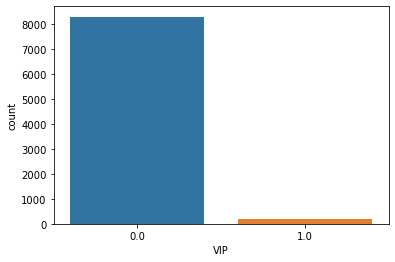

In [30]:
sns.countplot(x=data['VIP'],data=data)

<b> As we can see, there are much more passingers who are not vip, so I will fill missing data with non vip passingers.

In [ ]:
data['VIP'] = data['VIP'].fillna(0)

### Now l will see correlation with ,,HomePlanet,, column to fill Nan data

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

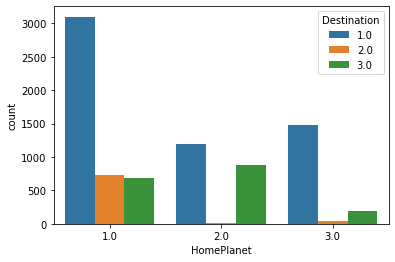

In [33]:
sns.countplot(x='HomePlanet',hue='Destination', data=data)

<b> If we look the graph we see that for the ,,HomePlanet,, number 3 is the most likely destination number 1.

In [34]:
data.loc[data.Destination == 2, 'HomePlanet'] = data.fillna(1)

### We will check if there is a good correlation between the money passinger spent and their Home planet

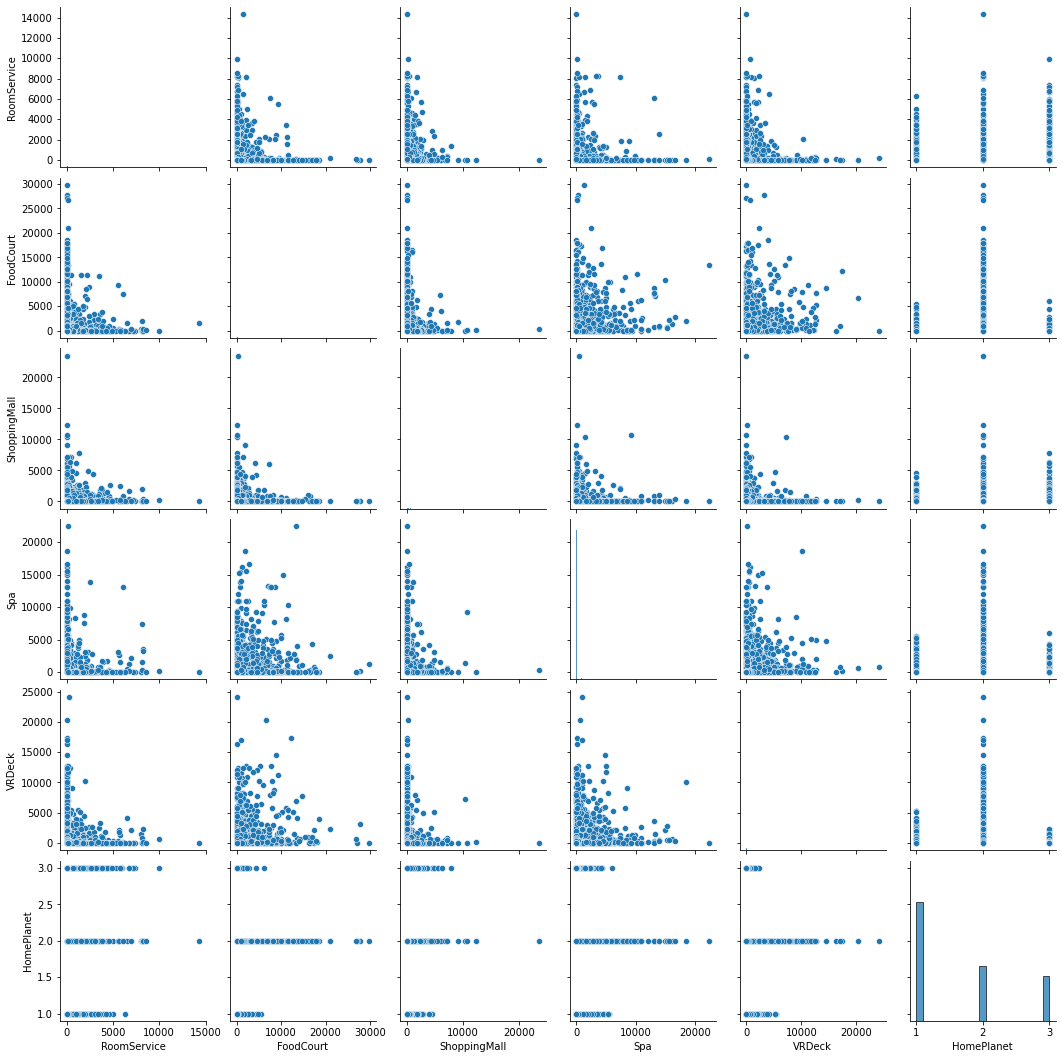

In [35]:
sns.pairplot(data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','HomePlanet']],palette='coolwarm')

**We have some correlation with planet number 2 and Spa,FoodCourt and VRDeck.**
<br>As we can see, that passingers from second planet spand much more money than in other two plantes.

In [38]:
data.loc[data.FoodCourt > 6300, 'HomePlanet'] = data['HomePlanet'].fillna(2)
data.loc[data.Spa > 6200, 'HomePlanet'] = data['HomePlanet'].fillna(2)
data.loc[data.VRDeck > 5500, 'HomePlanet'] = data['HomePlanet'].fillna(2)

<AxesSubplot:xlabel='Deck', ylabel='count'>

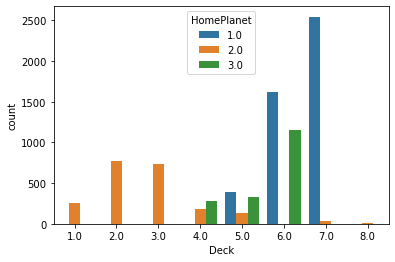

In [39]:
sns.countplot(x='Deck',hue='HomePlanet',data=data)

**Here we can see that passingers in 1,2,3,7 and 8 deck have the most passingers from one HomePlanet.**
<br>That will help us to fill missing values for HomePlanet

In [40]:
data.loc[data.Deck == 1, 'HomePlanet'] = data['HomePlanet'].fillna(2)
data.loc[data.Deck == 2, 'HomePlanet'] = data['HomePlanet'].fillna(2)
data.loc[data.Deck == 3, 'HomePlanet'] = data['HomePlanet'].fillna(2)
data.loc[data.Deck == 7, 'HomePlanet'] = data['HomePlanet'].fillna(1)
data.loc[data.Deck == 8, 'HomePlanet'] = data['HomePlanet'].fillna(2)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Group         8693 non-null   object 
 1   HomePlanet    8595 non-null   float64
 2   CryoSleep     8476 non-null   float64
 3   Deck          8600 non-null   float64
 4   Destination   8511 non-null   float64
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   float64
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(11), object(1)
memory usage: 823.6+ KB


**We still have some columns with missing values, let try to fill data for them too.**

### We will try to fill Nan values for Destination column

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

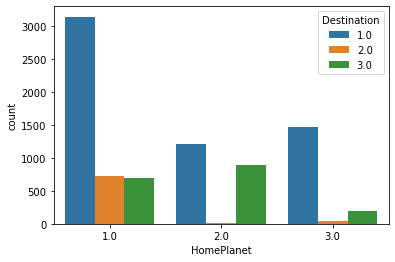

In [42]:
sns.countplot(x='HomePlanet',hue='Destination',data=data)

In [44]:
data.loc[data.HomePlanet == 3, 'Destination'] = data.fillna(1)

### Let see if there is a correlation with money that passingers spent

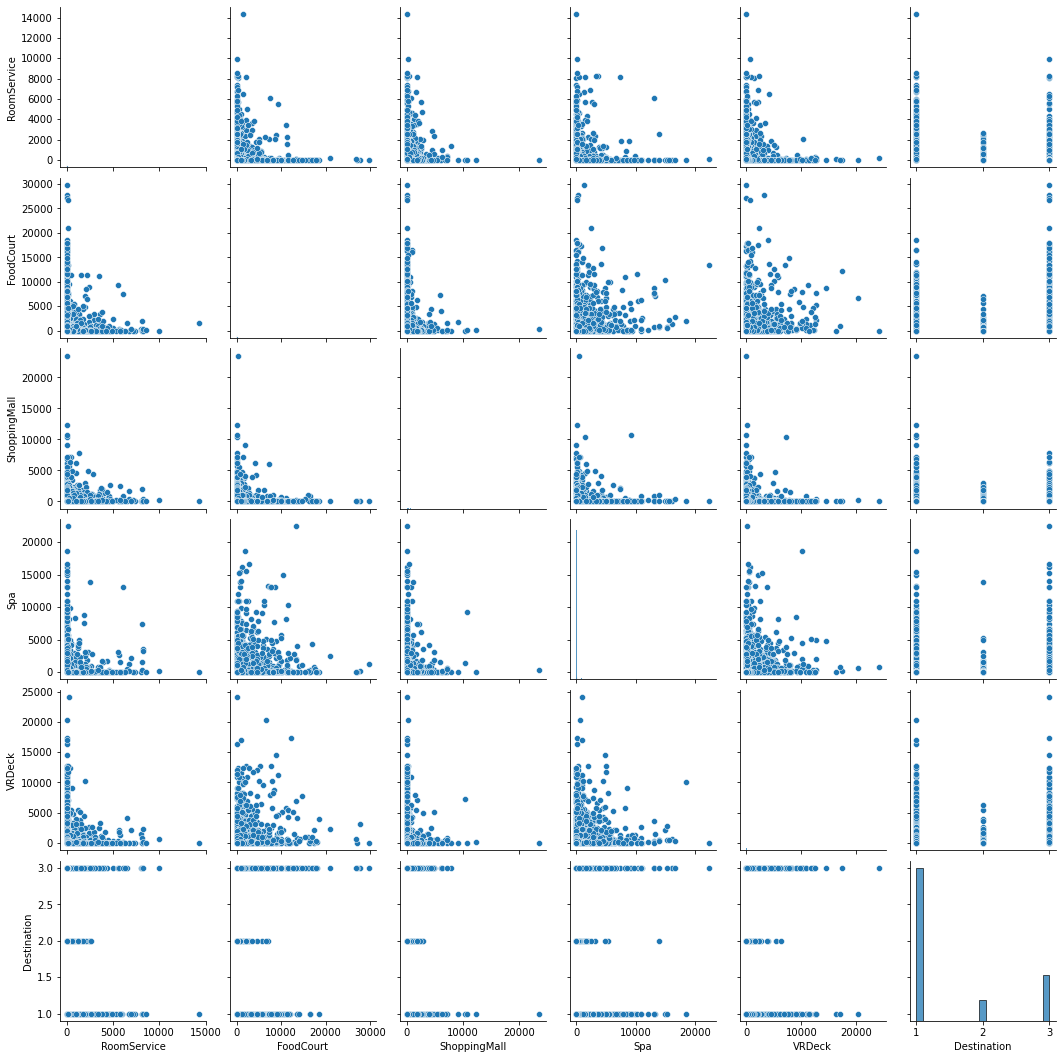

In [45]:
sns.pairplot(data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Destination']],palette='coolwarm')

**Only one correlation that we can use**

In [46]:
data.loc[data.FoodCourt > 20000, 'Destination'] = data.fillna(3)

In [47]:
data.loc[data.Destination == 3].max()

Group              9280
HomePlanet          3.0
CryoSleep           1.0
Deck                7.0
Destination         3.0
Age                78.0
VIP                 1.0
RoomService      9920.0
FoodCourt       29813.0
ShoppingMall     7810.0
Spa             22408.0
VRDeck          24133.0
Transported        True
dtype: object

<AxesSubplot:xlabel='Deck', ylabel='count'>

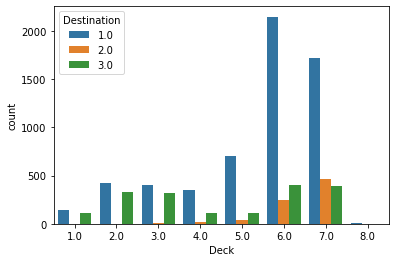

In [48]:
sns.countplot(x='Deck',hue='Destination',data=data)

**Here we can use Deck number 4,5,6 and 7 to fill missing valuse, because they are mostly travel to the Destination number 1.**

In [49]:
data.loc[data.Deck == 6, 'Destination'] = data['Destination'].fillna(1)
data.loc[data.Deck == 7, 'Destination'] = data['Destination'].fillna(1)
data.loc[data.Deck == 4, 'Destination'] = data['Destination'].fillna(1)
data.loc[data.Deck == 5, 'Destination'] = data['Destination'].fillna(1)

### The last column that we will process is "CryoSleep"
#### The procedure will be the same as it was for "HomePlanet" and "Destination" 

<AxesSubplot:xlabel='Transported', ylabel='count'>

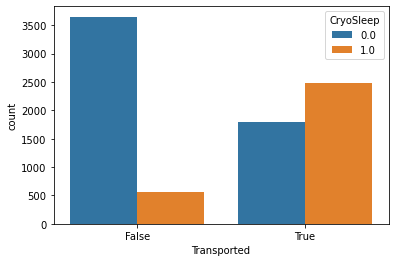

In [50]:
sns.countplot(x='Transported',hue='CryoSleep',data=data)

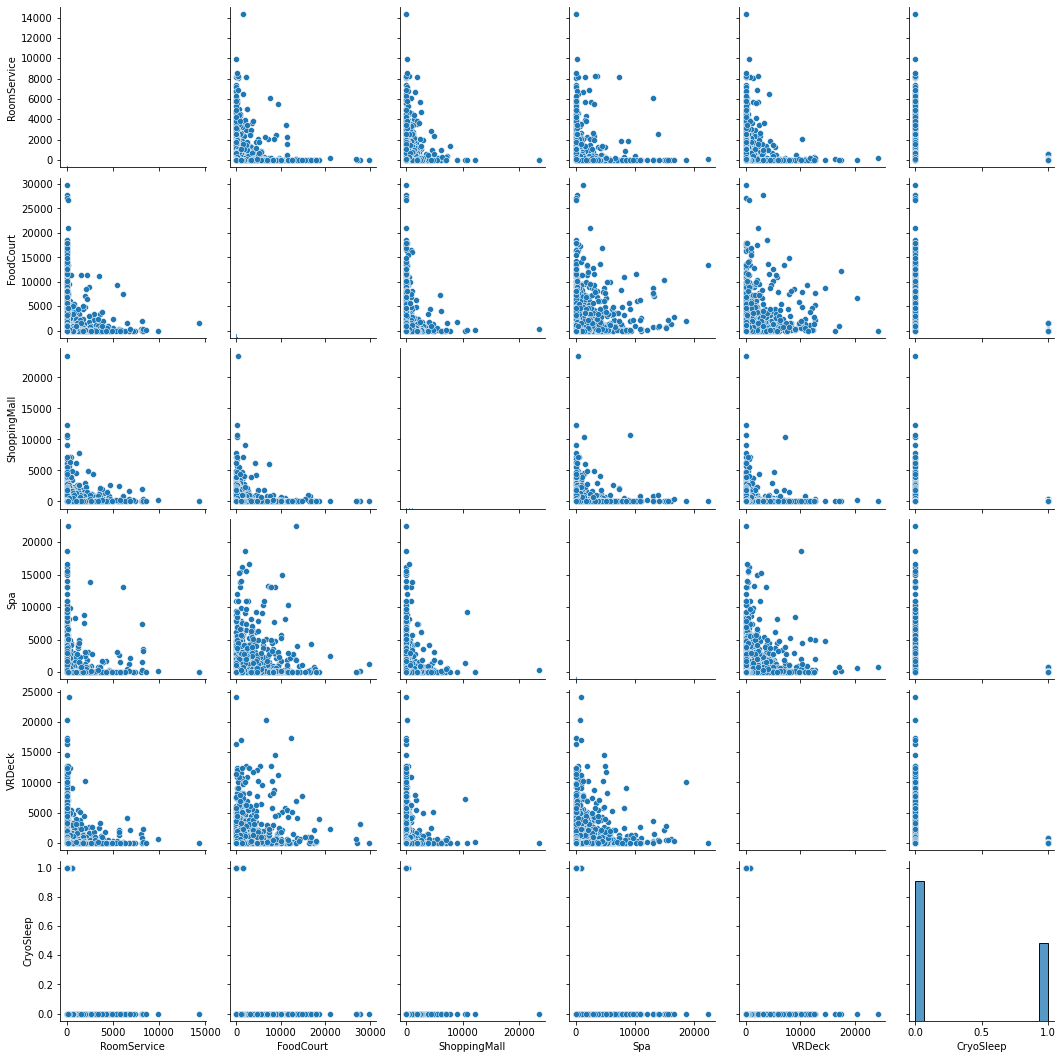

In [51]:
sns.pairplot(data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','CryoSleep']],palette='coolwarm')

In [53]:
data.loc[data.RoomService > 650, 'CryoSleep'] = data.fillna(0)
data.loc[data.FoodCourt > 1600, 'CryoSleep'] = data.fillna(0)
data.loc[data.ShoppingMall > 500, 'CryoSleep'] = data.fillna(0)
data.loc[data.Spa > 1000, 'CryoSleep'] = data.fillna(0)
data.loc[data.VRDeck > 1000, 'CryoSleep'] = data.fillna(0)

<AxesSubplot:xlabel='VIP', ylabel='count'>

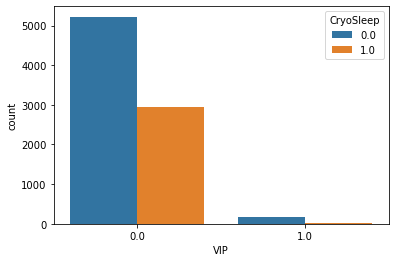

In [54]:
sns.countplot(x='VIP', hue='CryoSleep', data=data)

In [56]:
data.loc[data.VIP == 1, 'CryoSleep'] = data.fillna(0)

<AxesSubplot:xlabel='Transported', ylabel='count'>

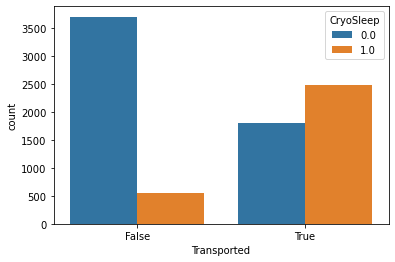

In [57]:
sns.countplot(x='Transported',hue='CryoSleep', data=data)

In [58]:
data.loc[data.Transported == False, 'CryoSleep'] = data.fillna(0)

<AxesSubplot:xlabel='Deck', ylabel='count'>

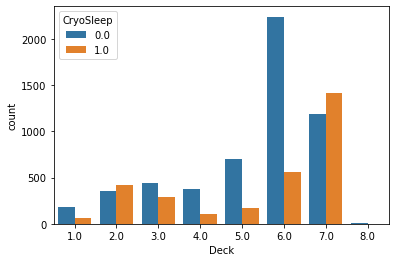

In [60]:
sns.countplot(x='Deck',hue='CryoSleep',data=data)

In [61]:
data.loc[data.Deck == 6, 'CryoSleep'] = data['CryoSleep'].fillna(0)
data.loc[data.Deck == 5, 'CryoSleep'] = data['CryoSleep'].fillna(0)
data.loc[data.Deck == 4, 'CryoSleep'] = data['CryoSleep'].fillna(0)

## Drop the NaN values
### We filled out all the values that we could. The rest we must drop, or our model won't be able to make valid predictions.

In [62]:
data.dropna(inplace=True)

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8054 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Group         8054 non-null   object 
 1   HomePlanet    8054 non-null   float64
 2   CryoSleep     8054 non-null   float64
 3   Deck          8054 non-null   float64
 4   Destination   8054 non-null   float64
 5   Age           8054 non-null   float64
 6   VIP           8054 non-null   float64
 7   RoomService   8054 non-null   float64
 8   FoodCourt     8054 non-null   float64
 9   ShoppingMall  8054 non-null   float64
 10  Spa           8054 non-null   float64
 11  VRDeck        8054 non-null   float64
 12  Transported   8054 non-null   bool   
dtypes: bool(1), float64(11), object(1)
memory usage: 825.8+ KB


<b>With droping rest of the Nan data we lost only 8% of our data, that will not be significant to our training model.
The risk is higher if we fill the rest of the data with dummy variables, so it is better for prediction model to drop that data.

## Now let export our processed data as csv file which we will use to train our model

In [73]:
data.to_csv('processed_train.csv', index = False)